<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/11_properties_of_kl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 11: Properties of the KL Divergence and Introduction to `pymc3` 


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: October 8th, 11:59pm EST

**Names of Group Members**: Anna Li (annajli@g.harvard.edu), Elain Cunha (mcunha@g.harvard.edu), Minhuan Li, minhuanli@g.harvard.edu, You Wu (youwu@g.harvard.edu), Johannes Kolberg (johanneskolberg@g.harvard.edu)

## Learning Goals:

1. Gain intuition for what it means to minimize the KL-divergence between a proposal distribution and a target distribution
2. Explore the benefits and draw-backs of variational inference with KL-divergence
2. Explore statistical modeling with `pymc3`


### Load necessary libraries

In [ ]:
### Import basic libraries
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pymc3 import model_to_graphviz, Model
import pymc3 as pm
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

In [ ]:
def scatter_plot_cancer_rates(data_df, estimates=None):
    ''' function for scatter plotting cancer rates vs population
        data_df is the dataframe of your data
        estimates_df is a numpy array of cancer rate estimates, one for each county 
    '''
    ax = data_df.plot(kind='scatter', x="pop", y="pct_mortality", alpha=0.1, color="grey", figsize=(10, 5))
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality', ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality', ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter', x="pop", y="pct_mortality", alpha=0.1, color="blue", ax=ax, label='highest rates', logx=True)
    bot_kcancer_counties.plot(kind='scatter', x="pop", y="pct_mortality", alpha=0.1, color="red", ax=ax, label='lowest rates', logx=True)
    if estimates is not None:
        ax.plot(data_df['pop'], 5 * estimates, '.', alpha=0.2, color="green")
    ax.set_ylim([-0.0001, 0.0003])
    return ax

## Problem 1: An Intuitive Feel For KL-divergence

In this problem, you will explore the properties of the KL-divergence and consider the impact of these properties on variational inference.

**Exercise 1:** To get an idea for what the KL-divergence measures, play the games in this website:
https://www.mdcrosby.com/blog/kldivergence.html.
The goal is to 'fit' a Gaussian distribution to a complex target distribution $p$ by minimizing $D_{\text{KL}}[\mathcal{N}(\mu, \sigma^2) \| p]$.

From your experiments, what does your variational distribution (the Gaussian) have to look like with respect to the target distribution in order to minimize the KL-divergence $D_{\text{KL}}[\mathcal{N}(\mu, \sigma^2) \| p]$?

**Answer:** In order to minimize the KL-divergence, the moments of the variational distribution must match up with the moments of the target distribution (i.e. mean and variance)

## Problem 2: Forward versus Reverse KL
Let the target distribution be a bivariate Gaussian $p(x) = \mathcal{N}(\mu_p, \Sigma_p)$, and let our variational family be isotropic bivariate Gaussians, 

$$Q = \{\mathcal{N}(\mu_q, \sigma^2_q I_{2\times 2}) \,|\, \sigma^2_q > 0, \mu_q\in \mathbb{R}^2\}.$$

A bit of matrix algebra allows us to write the KL-divergence between two Gaussians as

$$
D_{\text{KL}}[\mathcal{N}(\mu_1, \Sigma_1) \| \mathcal{N}(\mu_2, \Sigma_2)] = \frac{1}{2} \left[ \log\frac{|\Sigma_2|}{|\Sigma_1|} - D + \text{tr}\left\{ \Sigma_2^{-1} \Sigma_1\right\} + (\mu_2 - \mu_1)^\top \Sigma_2^{-1}(\mu_2 - \mu_1) \right]
$$

where $D$ is the dimension of the two Gaussians.

When we fit an isotropic Gaussian $\mathcal{N}(\mu_q, \Sigma_q)$ to a non-isotropic target Gaussian $\mathcal{N}(\mu_p, \Sigma_p)$ using the KL-divergence, we mean to find

$$
\mu^*_q, \Sigma^*_q = \underset{\mu_q, \Sigma_q}{\text{argmin}} D_{\text{KL}}[\mathcal{N}(\mu_q, \Sigma_q) \| \mathcal{N}(\mu_p, \Sigma_p)]
$$
This is often called minimizing the ***reverse KL-divergence***.
We can analytically solve this optimization problem, when we do, we get that

\begin{aligned}
\mu^*_q &= \mu_p\\
(\Sigma^*_q)_{ii} &= \frac{1}{(\Sigma_p^{-1})_{ii}}
\end{aligned}

But remember that choosing to minimize KL-divergence when we approximate $\mathcal{N}(\mu_p, \Sigma_p)$ is arbitrary. That is, we could have chosen another divergence measure. In particular, we could have chosen to minimize the ***forward KL-divergence***:

$$
\mu^*_q, \Sigma^*_q = \underset{\mu_q, \Sigma_q}{\text{argmin}} D_{\text{KL}}[\mathcal{N}(\mu_p, \Sigma_p)\|\mathcal{N}(\mu_q, \Sigma_q)]
$$

Analytically solve the above optimization problem gives us

\begin{aligned}
\mu^*_q &= \mu_p\\
(\Sigma_q)_{ii} &= (\Sigma_p)_{ii}
\end{aligned}

Is there any difference in minimizing these two different divergences? That is, does the following hold? 

$$
\underset{\mu_q, \Sigma_q}{\text{argmin}} D_{\text{KL}}[\mathcal{N}(\mu_q, \Sigma_q) \| \mathcal{N}(\mu_p, \Sigma_p)] \overset{?}{=}  \underset{\mu_q, \Sigma_q}{\text{argmin}} D_{\text{KL}}[\mathcal{N}(\mu_p, \Sigma_p)\|\mathcal{N}(\mu_q, \Sigma_q)]
$$

If not, which type of KL-divergence should we use when fitting an isotropic Gaussian $\mathcal{N}(\mu_q, \Sigma_q)$ to a non-isotropic target Gaussian $\mathcal{N}(\mu_p, \Sigma_p)$?

**Answer: ** Suppose $\Sigma_p = \left[\begin{array}{cc} a_{11} & a_{12}\\ a_{21} & a_{22} \end{array}\right]$. => $\Sigma_p^{-1} = \frac{1}{a_{11} a_{22} - a_{12} a_{21}}\left[\begin{array}{cc} a_{22} & -a_{12}\\ -a_{21} & a_{11} \end{array}\right]$

Then the optimized choice for reverse KL-divergence: $(\Sigma_{q}^{*})_{ii} = \frac{a_{11} a_{22} - a_{12} a_{21}}{a_{3-i, 3-i}}$.

For the forward KL-divergence, $(\Sigma_q)_{ii} = (\Sigma_p)_{ii} = a_{ii}$.

The following $
\underset{\mu_q, \Sigma_q}{\text{argmin}} D_{\text{KL}}[\mathcal{N}(\mu_q, \Sigma_q) \| \mathcal{N}(\mu_p, \Sigma_p)] \overset{?}{=}  \underset{\mu_q, \Sigma_q}{\text{argmin}} D_{\text{KL}}[\mathcal{N}(\mu_p, \Sigma_p)\|\mathcal{N}(\mu_q, \Sigma_q)]
$ only holds when $a_{12}, a_{21} = 0$.

Forward KL-divergence is definitely easier to compute, but the reverse KL-divergence looks like it captures more of the covariance information. 

**Exercise 2:** 

Using the code provided for this lab, experiment with
1. Approximating a bivariate Gaussian with correlation with an isotropic Gaussian (no correlation) by minimizing $D_{\text{KL}}[\mathcal{N}(\mu, \sigma^2) \| p]$. 

2. Approximate a bivariate Gaussian with correlation with an isotropic Gaussian (no correlation) by minimizing $D_{\text{KL}}[p\|\mathcal{N}(\mu, \sigma^2)]$, we call this the ***forward-KL***

Is the 'best' approximation in each case the same Gaussian? If not, describe the difference between the solutions found by optimizing the two different KL-divergences (visually compare the coutour maps of the resulting Gaussians, as well as the marginal distributions of each dimension)? 

Do you expect or want them to be the same (think about the definition of the KL-divergence)? Why or why not (think about what the KL-divergence is trying to quantify about two distributions, why might we want $D_{\text{KL}}[p\|q] = D_{\text{KL}}[q\|p]$)?

What do these properties of the KL-divergence imply about variational inference wherein we minimize the KL between a variational distribution and the target posterior?

**Answer:** The best approximation in each is not the same Gaussian. Wehn we optimize the two different KL-divergences, it looks like the parameters optimized using the reverse KL-divergence leads to a very concentrated Gaussian which does not match our proposal distribution as well as the parameters optimized using forward KL-divergence. We can visually see from marginal distributions that forward KL matches the proposal distribution much better. 

Intuitively the KL divergence measures the difference between two distributions so order should not matter (forward and reverse should give you the same answer) In other words, KL divergence should be order invariant, namely which ever order we put the two distributions should get the same difference. 

This implies that the choice of ordering in KL divergence, namely choosing either reverse or forward KL matters, and we need to choose wisely given the proposal family that we chose. 

In [ ]:
# functions to compute the optimal variational distribution under reverse and forward KL
reverse_kl = lambda mu_p, Sigma_p: (mu_p, np.diag(np.diag(np.linalg.inv(Sigma_p))**-1))
forward_kl = lambda mu_p, Sigma_p: (mu_p, np.diag(np.diag(Sigma_p)))

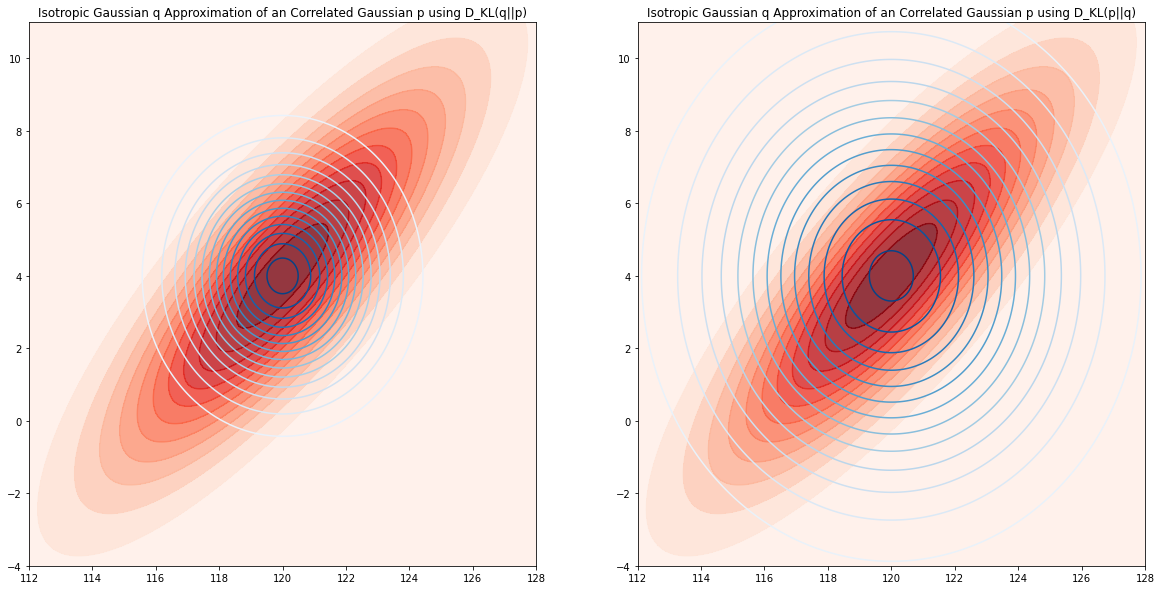

In [ ]:
#mean of the multivariate Gaussian
mu_p = [120, 4]
#covariance matrix of the multivariate Gaussian
Sigma_p = 10 * np.ones((2, 2)) + 2 * np.eye(2)
#optimal variational distribution using KL-divergence
mu_q, Sigma_q = reverse_kl(mu_p, Sigma_p)
#optimal variational distribution using forward KL-divergence
mu_q_forward, Sigma_q_forward = forward_kl(mu_p, Sigma_p)

#define points that include most of the probability mass of the pdf
x, y = np.mgrid[112:128:.01, -4:11:.01]
pos = np.dstack((x, y))
#get the value of the target pdf at those points
z_p = sp.stats.multivariate_normal(mu_p, Sigma_p).pdf(pos)
#get the value of the variational pdf at those points
z_q = sp.stats.multivariate_normal(mu_q, Sigma_q).pdf(pos)
z_q_forward = sp.stats.multivariate_normal(mu_q_forward, Sigma_q_forward).pdf(pos)

#plot the target density against variational densities
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#variational approximation using KL
ax[0].contourf(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[0].contour(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[0].contour(x, y, z_q, levels=14, cmap='Blues', alpha=1.)
ax[0].set_title('Isotropic Gaussian q Approximation of an Correlated Gaussian p using D_KL(q||p)')
ax[0].set_xlim([112, 128])
ax[0].set_ylim([-4, 11])
#variational approximation using forward KL
ax[1].contourf(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[1].contour(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[1].contour(x, y, z_q_forward, levels=14, cmap='Blues', alpha=1.)
ax[1].set_title('Isotropic Gaussian q Approximation of an Correlated Gaussian p using D_KL(p||q)')
ax[1].set_xlim([112, 128])
ax[1].set_ylim([-4, 11])

plt.show()

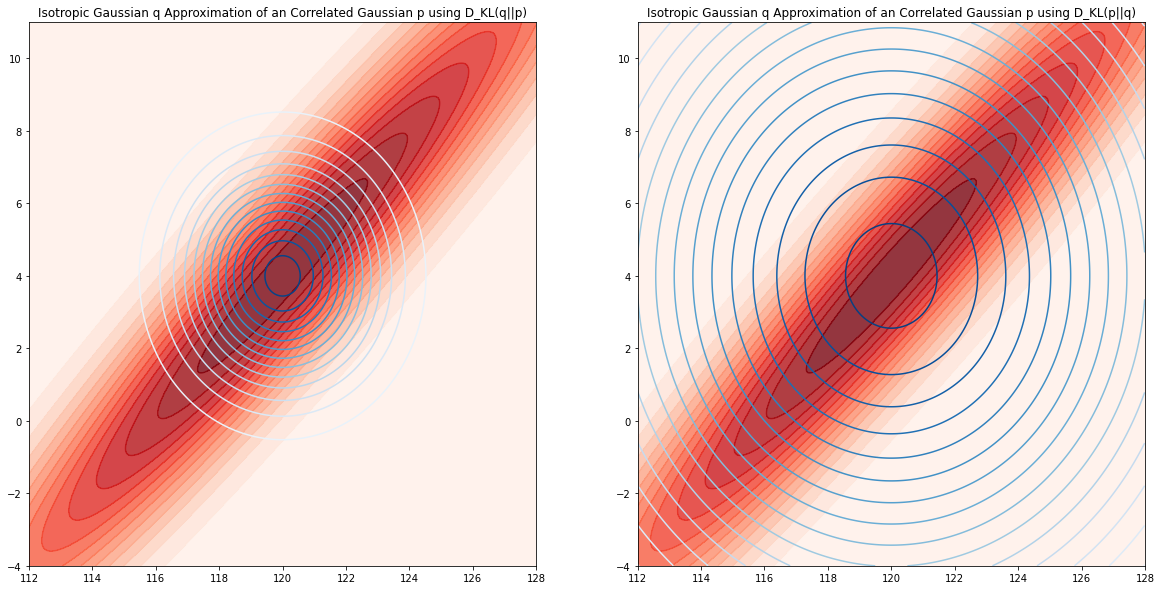

In [ ]:
#mean of the multivariate Gaussian
mu_p = [120, 4]
#covariance matrix of the multivariate Gaussian
Sigma_p = 50 * np.ones((2, 2)) + 2 * np.eye(2)
#optimal variational distribution using KL-divergence
mu_q, Sigma_q = reverse_kl(mu_p, Sigma_p)
#optimal variational distribution using forward KL-divergence
mu_q_forward, Sigma_q_forward = forward_kl(mu_p, Sigma_p)

#define points that include most of the probability mass of the pdf
x, y = np.mgrid[112:128:.01, -4:11:.01]
pos = np.dstack((x, y))
#get the value of the target pdf at those points
z_p = sp.stats.multivariate_normal(mu_p, Sigma_p).pdf(pos)
#get the value of the variational pdf at those points
z_q = sp.stats.multivariate_normal(mu_q, Sigma_q).pdf(pos)
z_q_forward = sp.stats.multivariate_normal(mu_q_forward, Sigma_q_forward).pdf(pos)

#plot the target density against variational densities
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#variational approximation using KL
ax[0].contourf(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[0].contour(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[0].contour(x, y, z_q, levels=14, cmap='Blues', alpha=1.)
ax[0].set_title('Isotropic Gaussian q Approximation of an Correlated Gaussian p using D_KL(q||p)')
ax[0].set_xlim([112, 128])
ax[0].set_ylim([-4, 11])
#variational approximation using forward KL
ax[1].contourf(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[1].contour(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax[1].contour(x, y, z_q_forward, levels=14, cmap='Blues', alpha=1.)
ax[1].set_title('Isotropic Gaussian q Approximation of an Correlated Gaussian p using D_KL(p||q)')
ax[1].set_xlim([112, 128])
ax[1].set_ylim([-4, 11])

plt.show()

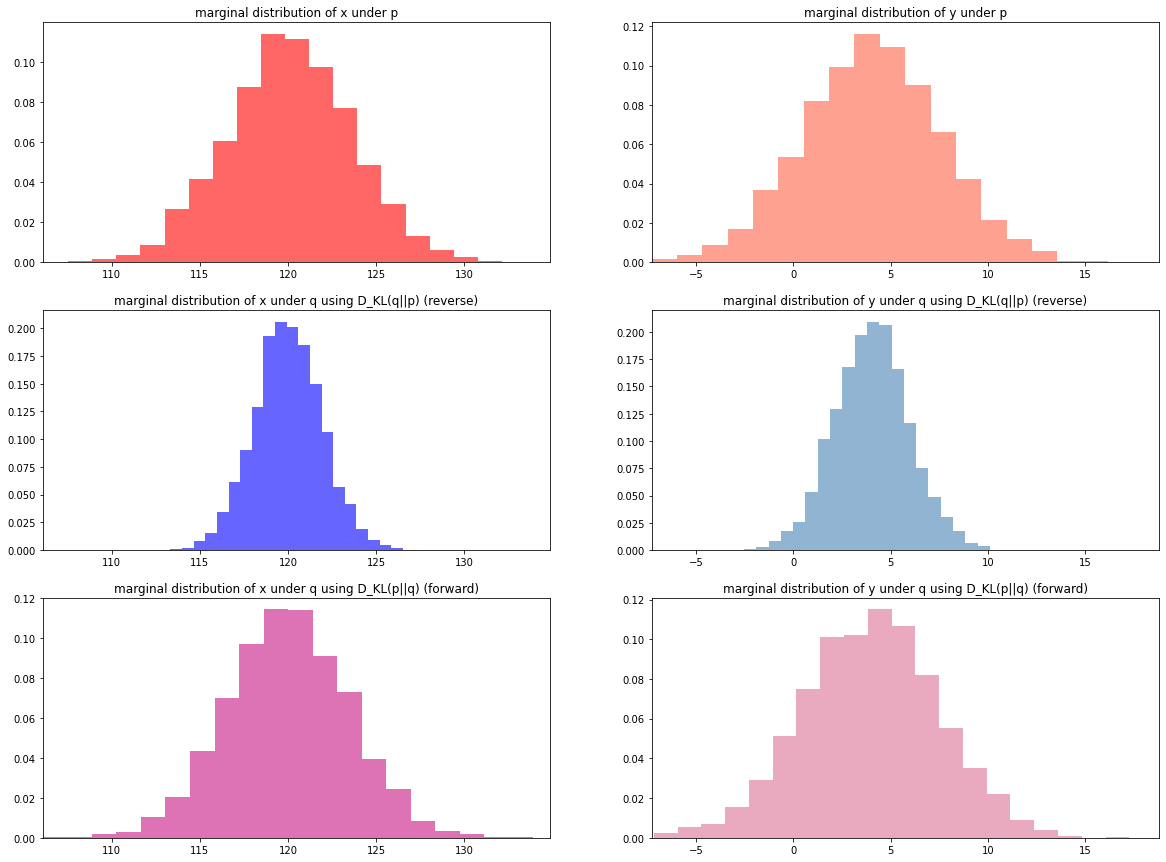

In [ ]:
S = 4000
#get samples from the target distribution
p_samples = np.random.multivariate_normal(mu_p, Sigma_p, size=S)
#get samples from the variational distribution
q_samples = np.random.multivariate_normal(mu_q, Sigma_q, size=S)
q_forward_samples = np.random.multivariate_normal(mu_q_forward, Sigma_q_forward, size=S)

x_min = np.min((p_samples[:, 0].min(), q_samples[:, 0].min(), q_forward_samples[:, 0].min()))
x_max = np.max((p_samples[:, 0].max(), q_samples[:, 0].max(), q_forward_samples[:, 0].max()))

y_min = np.min((p_samples[:, 1].min(), q_samples[:, 1].min(), q_forward_samples[:, 1].min()))
y_max = np.max((p_samples[:, 1].max(), q_samples[:, 1].max(), q_forward_samples[:, 1].max()))

#plot the marginals of the target and the variational distributions
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
ax[0, 0].hist(p_samples[:, 0], bins=20, density=True, color='red', alpha=0.6)
ax[0, 0].set_title('marginal distribution of x under p')
ax[0, 0].set_xlim([x_min, x_max])

ax[0, 1].hist(p_samples[:, 1], bins=20, density=True, color='tomato', alpha=0.6)
ax[0, 1].set_title('marginal distribution of y under p')
ax[0, 1].set_xlim([y_min, y_max])

ax[1, 0].hist(q_samples[:, 0], bins=20, density=True, color='blue', alpha=0.6)
ax[1, 0].set_xlim([x_min, x_max])
ax[1, 0].set_title('marginal distribution of x under q using D_KL(q||p) (reverse)')

ax[1, 1].hist(q_samples[:, 1], bins=20, density=True, color='steelblue', alpha=0.6)
ax[1, 1].set_xlim([y_min, y_max])
ax[1, 1].set_title('marginal distribution of y under q using D_KL(q||p) (reverse)')


ax[2, 0].hist(q_forward_samples[:, 0], bins=20, density=True, color='mediumvioletred', alpha=0.6)
ax[2, 0].set_xlim([x_min, x_max])
ax[2, 0].set_title('marginal distribution of x under q using D_KL(p||q) (forward)')

ax[2, 1].hist(q_forward_samples[:, 1], bins=20, density=True, color='palevioletred', alpha=0.6)
ax[2, 1].set_xlim([y_min, y_max])
ax[2, 1].set_title('marginal distribution of y under q using D_KL(p||q) (forward)')
plt.show()

---
## Problem 2: Introduction to `pymc3`

`pymc3` is a `python` package for building and performing inference on Bayesian statistical models. Notably, `pymc3` implements a number of popular approximate inference methods like Markov chain Monte Carlo (MCMC) and variational inference (VI). 

Along with core model specification and fitting functionality, PyMC3 includes functionality for summarizing output and for model diagnostics.

#### **Defining a Basic Model in `pymc3`**

After importing the library and instantiating a `pymc3` model:
```python
import pymc3 as pm
bayesian_model = pm.Model()
```
We defined our model using a context manager (`with` statement -- a `python` construct that manages the allocate and release resources involved with performing an action).

```python
#define hierarchical model in pymc3
with Model() as bayesian_model:
    #priors on theta
    theta = pm.Gamma('theta', alpha=alpha, beta=beta)
    #convert rate into number of disease incidents
    mu = theta * 5 * average_pop
    #likelihood
    y_obs = pm.Poisson('y', mu=mu, observed=y)
```

The model is specified declaratively inside the context manager.

#### **A Pooled Bayesian Model for the Kidney Cancer Data Set**

Suppose we treat all the cancer incidents $y_j$ across the US as iid samples from a ***single*** Poisson distribution $y_j \sim Poi(\theta)$, where $\theta$ is the same underlying rate for kidney cancer for every county. 

Is this a good way to model the Kidney cancer data?


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/kcancer.csv")
y = df['dc'].values
n = df['pop'].values
average_pop = n.mean()

In [ ]:
#hyperparameters of Bayesian model
alpha=1.
beta=10000.
 
#define hierarchical model in pymc3
with Model() as bayesian_model:
    #priors on theta
    theta = pm.Gamma('theta', alpha=alpha, beta=beta, shape=len(y))
    #convert rate into number of disease incidents
    mu = theta * 5 * average_pop
    #likelihood
    y_obs = pm.Poisson('y', mu=mu, observed=y)

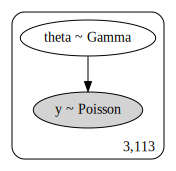

In [ ]:
#draw graphical model for the thing we just defined  
model_to_graphviz(bayesian_model)

#### **Inference Using `pymc3`**

A number of different samplers are implemented in `pymc3`. You have the flexibility of specifying different samplers for different variables in your model (e.g. you can implement a MH-in-Gibbs sampler using `pymc3`).

In [ ]:
#sample 1000 samples from the posterior of the model, using 1000 iterations to tune the sampler
#the default sampler for pymc3 is a type of MCMC sampler called No-U-turn HMC, 
#which we have not covered in class
with bayesian_model:
    #specifying a specific sampler
    steps = pm.Metropolis(vars=[theta, mu])
    #use the specify sampler to sample from the posterior of the model
    trace = pm.sample(1000, step=steps, tune=1000)
    #using default sampler
#     trace = pm.sample(1000, tune=1000)

Sequential sampling (2 chains in 1 job)
Metropolis: [theta]
100%|██████████| 2000/2000 [00:01<00:00, 1142.76it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


#### **Diagnostics Using `pymc3`**

`pymc3` implements also a large number of convergence diagnostics for MCMC samplers -- traceplots, auto-correlation plots, Gelman-Rubin statistic etc.

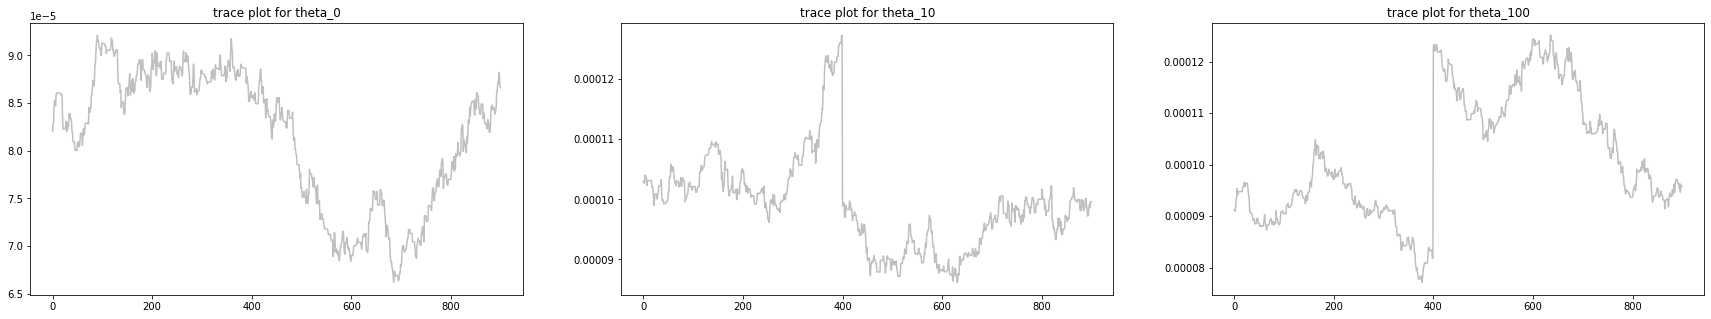

In [ ]:
#defined burn-in
burn_in = .1
#define thinning
thin = 2
#select the county to visualize the traceplot for theta
county_1 = 0
county_2 = 10
county_3 = 100

#plot the traceplots for one theta and alpha and beta
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
N = len(trace['theta'].T[county_1])
theta_trace = trace['theta'][int(burn_in * N)::thin].T[county_1]
ax[0].plot(range(len(theta_trace)), theta_trace, color='gray', alpha=0.5)
ax[0].set_title('trace plot for theta_{}'.format(county_1))

theta_trace = trace['theta'][int(burn_in * N)::thin].T[county_2]
ax[1].plot(range(len(theta_trace)), theta_trace, color='gray', alpha=0.5)
ax[1].set_title('trace plot for theta_{}'.format(county_2))

theta_trace = trace['theta'][int(burn_in * N)::thin].T[county_3]
ax[2].plot(range(len(theta_trace)), theta_trace, color='gray', alpha=0.5)
ax[2].set_title('trace plot for theta_{}'.format(county_3))
plt.show()

## Posterior Predictive Sampling with `pymc3`

Given the trace and the model, `pymc3` can also automatically sample from the posterior predictive.

In [ ]:
pp_samples = pm.sample_posterior_predictive(trace, samples=1000, model=bayesian_model)
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].hist(y, bins=30, density=True, color='gray', alpha=0.8)
ax[0].set_xlim([0, 200])
ax[0].set_title('histogram of cancer incidents across counties')
ax[1].hist(pp_samples['y'].flatten(), bins=20, density=True, color='red', alpha=0.3)
ax[1].set_title('histogram of simulated cancer incidents from the posterior predictive across counties')
plt.show()

**Exercise 3:** Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size (in log-scale). Highlight the top 300 raw cancer rates (number of cancer incidents divided by the total population in the county) in red. Highlight the bottom 300 raw cancer rates in blue. What can you say about the counties with the highest and lowest raw cancer rates?

Implement the hiearchical model for kidney cancer rates from Homework #4 in `pymc3`:

\begin{aligned}
y_j| \theta_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j | \alpha, \beta &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a=9, b=6, c=9, d=0.00001$. 

Scatter plot the mean of the posterior marginal distribution over $\theta_j$, i.e. $p(\theta_j|y_1, \ldots, y_N)$, vs the county population size, highlight these means in green. What is the difference between the raw cancer rates and the posterior mean estimates of $\theta_j$?


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/kcancer.csv")
y = df['dc'].values
n = df['pop'].values
average_pop = n.mean()

In [ ]:
#hyperparameters of Bayesian model
a = 9
b = 6
c = 9
d = 0.00001
 
#define hierarchical model in pymc3
with Model() as bayesian_model:
    #priors on alpha, beta
    alpha = pm.Gamma('alpha', alpha=a, beta=b)
    beta = pm.Gamma('beta', alpha=c, beta=d)
    #priors on theta
    theta = pm.Gamma('theta', alpha=alpha, beta=beta, shape=len(y))
    #convert rate into number of disease incidents
    mu = theta * 5 * average_pop
    #likelihood
    y_obs = pm.Poisson('y', mu=mu, observed=y)

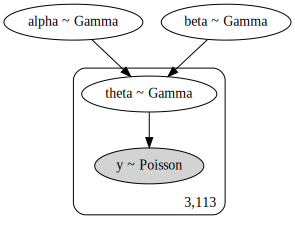

In [ ]:
#draw graphical model for the thing we just defined  
model_to_graphviz(bayesian_model)

In [ ]:
#sample 1000 samples from the posterior of the model, using 1000 iterations to tune the sampler
#the default sampler for pymc3 is a type of MCMC sampler called No-U-turn HMC, 
#which we have not covered in class
with bayesian_model:
    #specifying a specific sampler
    steps = pm.Metropolis(vars=[theta, mu])
    #use the specify sampler to sample from the posterior of the model
    trace = pm.sample(1000, step=steps, tune=1000)
    #using default sampler
#     trace = pm.sample(1000, tune=1000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [theta]
>NUTS: [beta, alpha]
100%|██████████| 2000/2000 [00:20<00:00, 95.60it/s]
The acceptance probability does not match the target. It is 0.9303106711909199, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9148071805380511, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


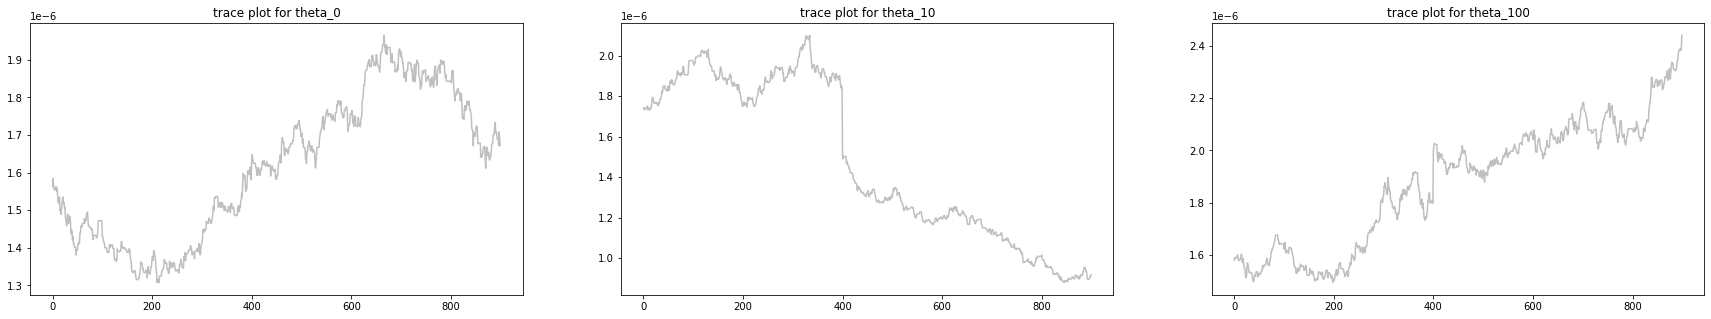

In [ ]:
#defined burn-in
burn_in = .1
#define thinning
thin = 2
#select the county to visualize the traceplot for theta
county_1 = 0
county_2 = 10
county_3 = 100

#plot the traceplots for one theta and alpha and beta
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
N = len(trace['theta'].T[county_1])
theta_trace = trace['theta'][int(burn_in * N)::thin].T[county_1]
ax[0].plot(range(len(theta_trace)), theta_trace, color='gray', alpha=0.5)
ax[0].set_title('trace plot for theta_{}'.format(county_1))

theta_trace = trace['theta'][int(burn_in * N)::thin].T[county_2]
ax[1].plot(range(len(theta_trace)), theta_trace, color='gray', alpha=0.5)
ax[1].set_title('trace plot for theta_{}'.format(county_2))

theta_trace = trace['theta'][int(burn_in * N)::thin].T[county_3]
ax[2].plot(range(len(theta_trace)), theta_trace, color='gray', alpha=0.5)
ax[2].set_title('trace plot for theta_{}'.format(county_3))
plt.show()

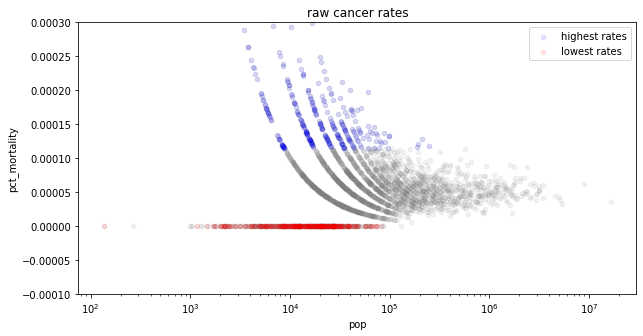

In [ ]:
ax = scatter_plot_cancer_rates(df)
ax.set_title('raw cancer rates')
plt.show()